<a href="https://colab.research.google.com/github/Nitin-Shukla-eng/Text-Classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tf-keras --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras



In [4]:
df=pd.read_csv("/content/wine-reviews (1).csv", usecols=['country','description','points','price','variety','winery'])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [7]:
df=df.dropna(subset=["description","points"])

In [8]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


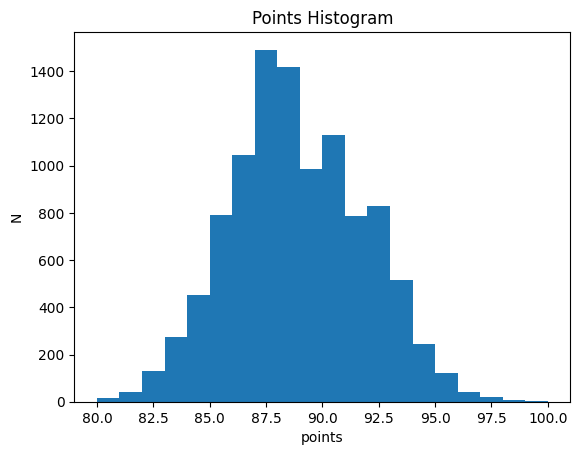

In [9]:
plt.hist(df.points,bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("points")
plt.show()

In [10]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","label"]]

In [11]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
#from tensorflow.python.ops.gen_experimental_dataset_ops import data_service_dataset_v2_eager_fallback
def df_to_dataset(dataframe,shuffle=True,batch_size=1024):
  df=dataframe.copy()
  labels=df.pop('label')
  df=df["description"]
  #df={key:value[:,tf.newaxis] for keu,value in dataframe.items()}
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [13]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [14]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Light golden in color, this is exotic in ginger and lemongrass, with a midpalate of fresh-cut pear and wet stone. Gearing up to the finish, expect deeper tones of caramel and tropical oak.',
        b'Aromas of mineral, flowers and freshly cut green apple are followed by a just off-dry, lightly spritzy palate full of stone-fruit flavors.',
        b'This is an open and ready-to-drink wine that has soft tannins and juicy blackberry fruit. With 50% Aragonez in the blend, it is has a smooth character that brings out plenty fruit and not too much structure. Drink now.',
        ...,
        b"Here's an enticing Vino Nobile offering aromas of underbrush, tobacco leaf, ripe cherry and spice. The palate delivers succulent black cherry, plum, cinnamon and nutmeg along with velvety tannins. Although it shows the warmth of the vintage, it still retains elegance and class. Delicatio Wines, Golden Vines.",
        b'Ripe, dusty fruits domi

#Embedding+Model

In [15]:
embedding="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,dtype=tf.string,trainable=True)


In [16]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.47765264,  0.00822044,  0.04781393, ..., -0.14964284,
        -0.02131642,  0.17011903],
       [ 0.31233254, -0.4144491 , -0.20742775, ...,  0.12298893,
         0.03185237, -0.06270985],
       [ 0.3204052 , -0.25431478,  0.1314403 , ..., -0.10310818,
        -0.2000915 ,  0.1264787 ],
       ...,
       [ 0.27204895, -0.2473527 ,  0.01158998, ..., -0.27292678,
        -0.06299052, -0.11477111],
       [ 0.15131146,  0.09341477,  0.20490596, ..., -0.06381396,
        -0.15139079,  0.11539917],
       [ 0.17098549, -0.3867736 ,  0.05593184, ...,  0.10730629,
         0.03267659,  0.13498041]], dtype=float32)>

In [17]:
print(type(hub_layer))

<class 'tensorflow_hub.keras_layer.KerasLayer'>


In [33]:
model=keras.Sequential([
  hub_layer,
  keras.layers.Dense(16,activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(16,activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(1,activation='sigmoid')

])

In [37]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [38]:
model.evaluate(train_data)

9/9 [==============================] - 2s 33ms/step - loss: 0.6963 - accuracy: 0.4808


[0.6963499784469604, 0.48076921701431274]

In [39]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 10ms/step - loss: 0.6983 - accuracy: 0.4526


[0.6982746124267578, 0.45261120796203613]

#LSTM


In [40]:
encoder = keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [42]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    keras.layers.LSTM(32),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [47]:
model.evaluate(train_data)
model.evaluate(valid_data)

2/2 [==============================] - 0s 12ms/step - loss: 0.6935 - accuracy: 0.4478


[0.6935192346572876, 0.44777563214302063]

In [48]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
9/9 [==============================] - 10s 389ms/step - loss: 0.6874 - accuracy: 0.6160 - val_loss: 0.6747 - val_accuracy: 0.6451
Epoch 2/5
9/9 [==============================] - 3s 361ms/step - loss: 0.6634 - accuracy: 0.6433 - val_loss: 0.6441 - val_accuracy: 0.6451
Epoch 3/5
9/9 [==============================] - 4s 506ms/step - loss: 0.6431 - accuracy: 0.6433 - val_loss: 0.6284 - val_accuracy: 0.6451
Epoch 4/5
9/9 [==============================] - 4s 432ms/step - loss: 0.6224 - accuracy: 0.6433 - val_loss: 0.6015 - val_accuracy: 0.6451
Epoch 5/5
9/9 [==============================] - 3s 358ms/step - loss: 0.5857 - accuracy: 0.6486 - val_loss: 0.5478 - val_accuracy: 0.7012


In [49]:
model.evaluate(test_data)

2/2 [==============================] - 0s 20ms/step - loss: 0.5680 - accuracy: 0.6741


[0.5679983496665955, 0.6740812659263611]